In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

np.random.seed(3534746)

In [15]:
time = np.loadtxt('http://ogledb.astrouw.edu.pl/~ogle/OCVS/data/I/01/OGLE-LMC-RRLYR-00001.dat',usecols=0)

In [16]:
def lc_model(time):
    P = 0.415517 # days
    freq = 1/P
    A0 = 15.821 # mag
    A1 = 0.351  #mag
    phi1 = 4.99
    R21 = 0.522
    R31 = 0.451
    R41 = 0.239
    phi21 = 3.53 # rad
    phi31 = 1.50 # rad
    phi41 = 5.81 # rad
    
    A2 = A1*R21
    A3 = A1*R31
    A4 = A1*R41
    phi2 = phi21 + 2*phi1
    phi3 = phi31 + 3*phi1
    phi4 = phi41 + 4*phi1
    
    lc = A0 + A1*np.sin( 2*np.pi*1*freq*time + phi1 ) \
            + A2*np.sin( 2*np.pi*2*freq*time + phi2 ) \
            + A3*np.sin( 2*np.pi*3*freq*time + phi3 ) \
            + A4*np.sin( 2*np.pi*4*freq*time + phi4 )
            
    return lc

In [17]:
def add_noise(mag,sig = 0.2,outlier_sig = 1):
    noise = np.random.normal(0,sig,len(mag))

    mag_noise = mag+noise

    outliers = np.random.normal(0,outlier_sig,len(mag))

    mag_noise_outlier = mag_noise.copy()
    for i in np.random.randint(0,len(mag),int( len(mag)/10) ):
        mag_noise_outlier[i] = mag_noise_outlier[i] + outliers[i]
        
    return mag_noise,mag_noise_outlier

In [18]:
mag = lc_model(time)

P =  0.415517
t0 = P/1.9

mag_noise,mag_noise_outlier = add_noise(mag,sig = 0.2)

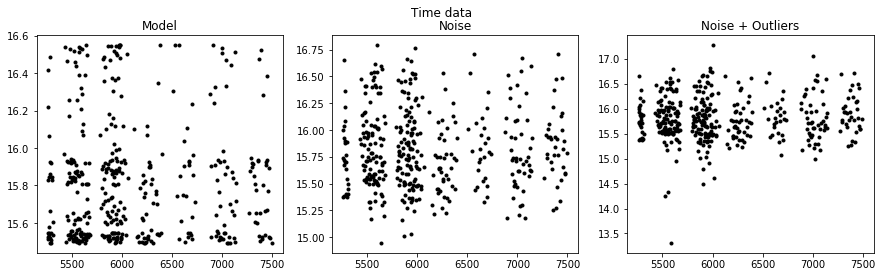

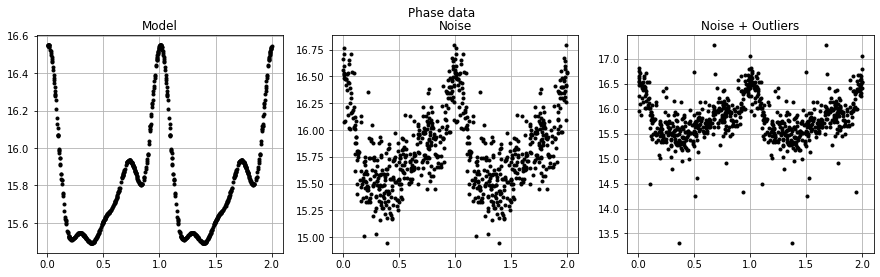

In [19]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))

ax1.plot(time,mag,'k.')
ax2.plot(time,mag_noise,'k.')
ax3.plot(time,mag_noise_outlier,'k.')
plt.suptitle('Time data')
ax1.set_title('Model')
ax2.set_title('Noise')
ax3.set_title('Noise + Outliers')
plt.show()

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))

ax1.plot((time-t0)%P/P,mag,'k.')
ax1.plot((time-t0)%P/P+1,mag,'k.')
ax1.grid()

ax2.plot((time-t0)%P/P,mag_noise,'k.')
ax2.plot((time-t0)%P/P+1,mag_noise,'k.')
ax2.grid()

ax3.plot((time-t0)%P/P,mag_noise_outlier,'k.')
ax3.plot((time-t0)%P/P+1,mag_noise_outlier,'k.')
ax3.grid()
plt.suptitle('Phase data')
ax1.set_title('Model')
ax2.set_title('Noise')
ax3.set_title('Noise + Outliers')
plt.show()

In [20]:
def sigma_clip(mag,sigma=4):
    dummy_mag = mag.copy()
    um =  dummy_mag > dummy_mag.mean() + sigma*dummy_mag.std()
    um2 = dummy_mag < dummy_mag.mean() - sigma*dummy_mag.std()
    
    dummy_mag[um]  = np.nan
    dummy_mag[um2] = np.nan
    
    um_non_nan = np.isfinite(dummy_mag)
    
    return dummy_mag[um_non_nan]

In [21]:
def sigma_clip_filtered(time,mag,t0,P,sigma=4,window_length=125,polyorder=2):
    dummy_mag = mag.copy()
    
    phase = (time-t0)%P/P
    phase_sorted = np.sort(phase)
    order = np.argsort(phase)
    dummy_mag_sorted = dummy_mag[order]

    dummy_mag_sorted_smoothed = savgol_filter(dummy_mag_sorted,window_length,polyorder)
    dummy_mag_sorted_residual = dummy_mag_sorted - dummy_mag_sorted_smoothed
    
    um =  dummy_mag_sorted_residual > dummy_mag_sorted_residual.mean() + sigma*dummy_mag_sorted_residual.std()
    um2 = dummy_mag_sorted_residual < dummy_mag_sorted_residual.mean() - sigma*dummy_mag_sorted_residual.std()
    
    dummy_mag_sorted[um]  = np.nan
    dummy_mag_sorted[um2] = np.nan
    
    um_non_nan = np.isfinite(dummy_mag_sorted)
    
    return phase_sorted[um_non_nan],dummy_mag_sorted[um_non_nan],dummy_mag_sorted_smoothed[um_non_nan]

In [22]:
mag_clean2 = sigma_clip(mag_noise_outlier,sigma=2)
mag_clean3 = sigma_clip(mag_noise_outlier,sigma=3)
mag_clean4 = sigma_clip(mag_noise_outlier,sigma=4)

In [23]:
phase_sorted, mag_clean4_sorted, mag_fitted = sigma_clip_filtered(time,mag_noise_outlier,t0,P,
                                                      sigma=4,window_length=121,polyorder=2)
phase_sorted, mag_clean3_sorted, mag_fitted = sigma_clip_filtered(time,mag_noise_outlier,t0,P,
                                                      sigma=3,window_length=121,polyorder=2)
phase_sorted, mag_clean2_sorted, mag_fitted = sigma_clip_filtered(time,mag_noise_outlier,t0,P,
                                                      sigma=2,window_length=121,polyorder=2)

# Sigma clipping if noise is high

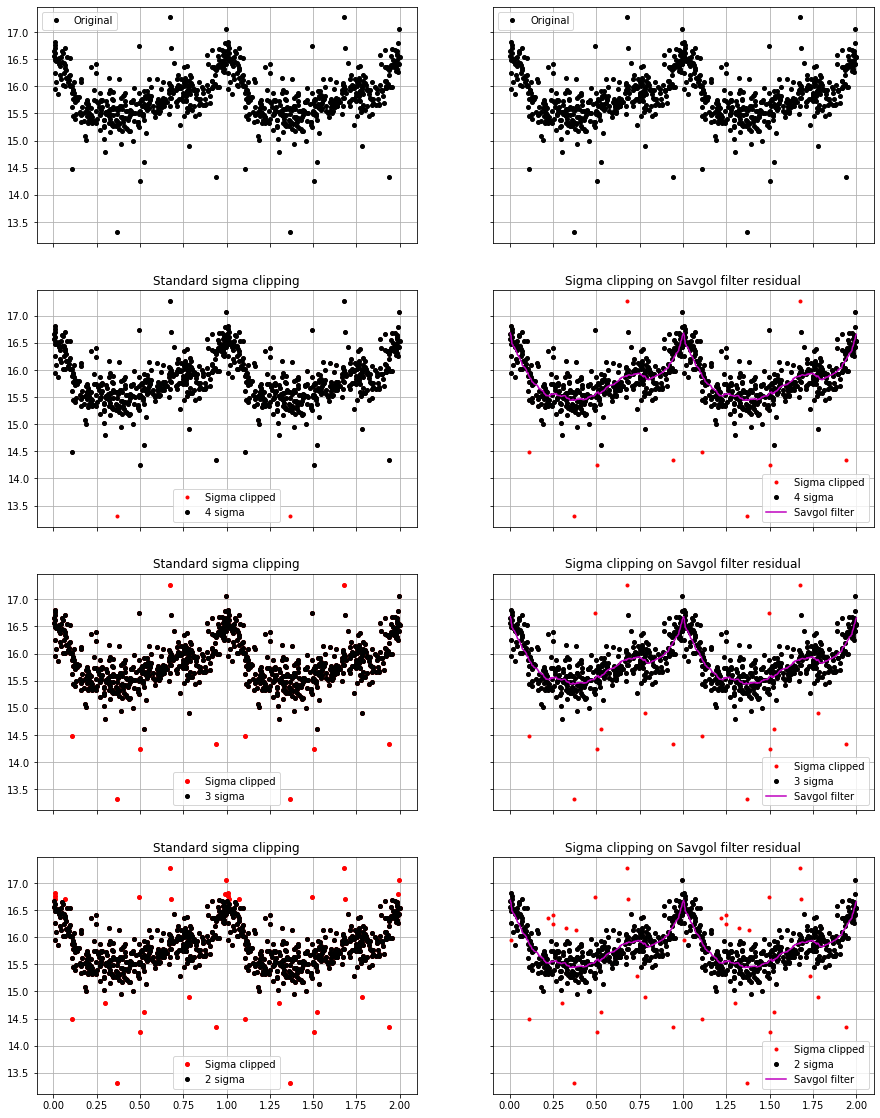

In [24]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2,figsize=(15,20),sharex=True,sharey=True)

ax1.plot((time-t0)%P/P,mag_noise_outlier,'k.',ms=8,label='Original')
ax1.plot((time-t0)%P/P+1,mag_noise_outlier,'k.',ms=8)
ax1.grid()
ax1.legend()

ax2.plot((time-t0)%P/P,mag_noise_outlier,'k.',ms=8,label='Original')
ax2.plot((time-t0)%P/P+1,mag_noise_outlier,'k.',ms=8)
ax2.grid()
ax2.legend()

ax3.plot((time-t0)%P/P,mag_noise_outlier,'.',c='red',label='Sigma clipped')
ax3.plot((time-t0)%P/P+1,mag_noise_outlier,'.',c='red')
ax3.plot((time-t0)%P/P,mag_clean4,'k.',ms=8,label='4 sigma')
ax3.plot((time-t0)%P/P+1,mag_clean4,'k.',ms=8)
ax3.grid()
ax3.legend()
ax3.set_title('Standard sigma clipping')

ax4.plot((time-t0)%P/P,mag_noise_outlier,'.',c='red',label='Sigma clipped')
ax4.plot((time-t0)%P/P+1,mag_noise_outlier,'.',c='red')
ax4.plot(phase_sorted,mag_clean4_sorted,'k.',ms=8,label='4 sigma')
ax4.plot(phase_sorted+1,mag_clean4_sorted,'k.',ms=8)
ax4.plot(phase_sorted,mag_fitted,'m',label='Savgol filter')
ax4.plot(phase_sorted+1,mag_fitted,'m')
ax4.legend()
ax4.grid()
ax4.set_title('Sigma clipping on Savgol filter residual')

ax5.plot((time-t0)%P/P,mag_noise_outlier,'.',ms=8,c='red',label='Sigma clipped')
ax5.plot((time-t0)%P/P+1,mag_noise_outlier,'.',ms=8,c='red')
ax5.plot((time-t0)%P/P,mag_clean3,'k.',ms=8,label='3 sigma')
ax5.plot((time-t0)%P/P+1,mag_clean3,'k.',ms=8)
ax5.grid()
ax5.legend()
ax5.set_title('Standard sigma clipping')

ax6.plot((time-t0)%P/P,mag_noise_outlier,'.',c='red',label='Sigma clipped')
ax6.plot((time-t0)%P/P+1,mag_noise_outlier,'.',c='red')
ax6.plot(phase_sorted,mag_clean3_sorted,'k.',ms=8,label='3 sigma')
ax6.plot(phase_sorted+1,mag_clean3_sorted,'k.',ms=8)
ax6.plot(phase_sorted,mag_fitted,'m',label='Savgol filter')
ax6.plot(phase_sorted+1,mag_fitted,'m')
ax6.legend()
ax6.grid()
ax6.set_title('Sigma clipping on Savgol filter residual')

ax7.plot((time-t0)%P/P,mag_noise_outlier,'.',ms=8,c='red',label='Sigma clipped')
ax7.plot((time-t0)%P/P+1,mag_noise_outlier,'.',ms=8,c='red')
ax7.plot((time-t0)%P/P,mag_clean2,'k.',ms=8,label='2 sigma')
ax7.plot((time-t0)%P/P+1,mag_clean2,'k.',ms=8)
ax7.grid()
ax7.legend()
ax7.set_title('Standard sigma clipping')

ax8.plot((time-t0)%P/P,mag_noise_outlier,'.',c='red',label='Sigma clipped')
ax8.plot((time-t0)%P/P+1,mag_noise_outlier,'.',c='red')
ax8.plot(phase_sorted,mag_clean2_sorted,'k.',ms=8,label='2 sigma')
ax8.plot(phase_sorted+1,mag_clean2_sorted,'k.',ms=8)
ax8.plot(phase_sorted,mag_fitted,'m',label='Savgol filter')
ax8.plot(phase_sorted+1,mag_fitted,'m')
ax8.legend()
ax8.grid()
ax8.set_title('Sigma clipping on Savgol filter residual')

plt.show()

# Sigma clipping if noise is low

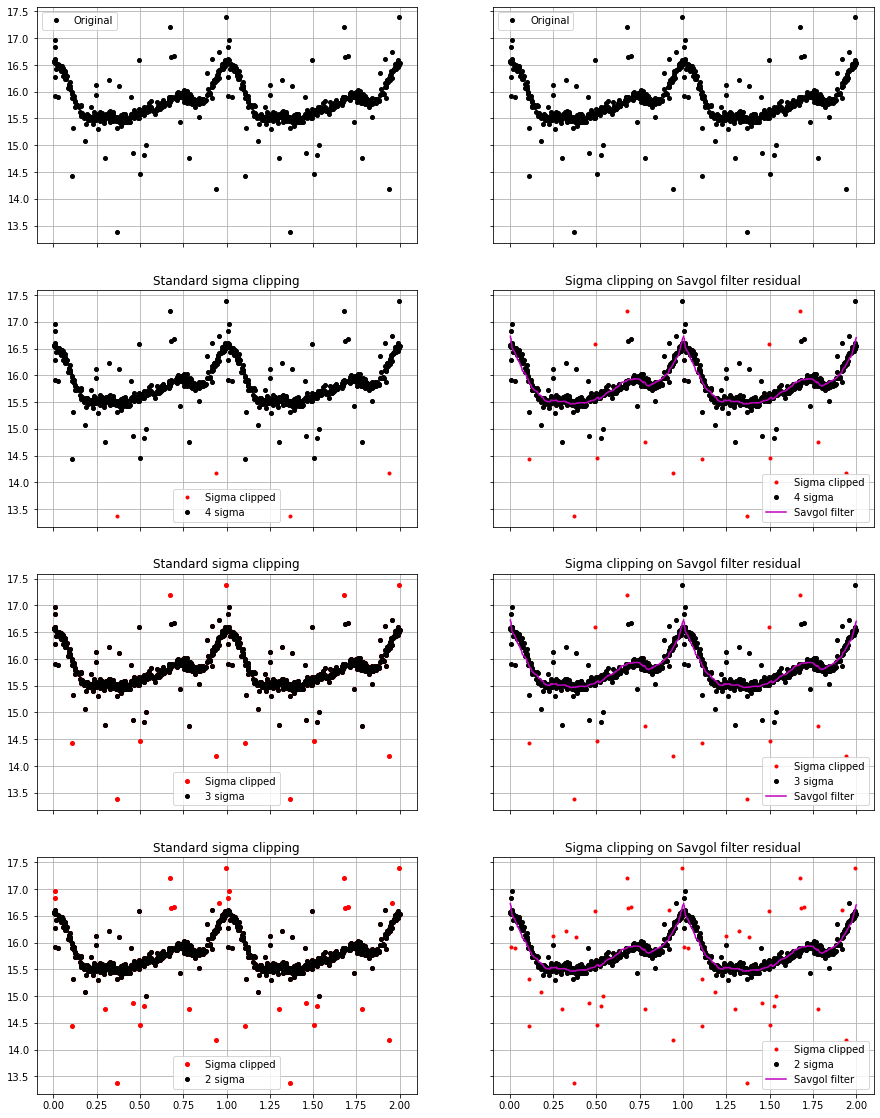

In [13]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4,2,figsize=(15,20),sharex=True,sharey=True)

ax1.plot((time-t0)%P/P,mag_noise_outlier,'k.',ms=8,label='Original')
ax1.plot((time-t0)%P/P+1,mag_noise_outlier,'k.',ms=8)
ax1.grid()
ax1.legend()

ax2.plot((time-t0)%P/P,mag_noise_outlier,'k.',ms=8,label='Original')
ax2.plot((time-t0)%P/P+1,mag_noise_outlier,'k.',ms=8)
ax2.grid()
ax2.legend()

ax3.plot((time-t0)%P/P,mag_noise_outlier,'.',c='red',label='Sigma clipped')
ax3.plot((time-t0)%P/P+1,mag_noise_outlier,'.',c='red')
ax3.plot((time-t0)%P/P,mag_clean4,'k.',ms=8,label='4 sigma')
ax3.plot((time-t0)%P/P+1,mag_clean4,'k.',ms=8)
ax3.grid()
ax3.legend()
ax3.set_title('Standard sigma clipping')

ax4.plot((time-t0)%P/P,mag_noise_outlier,'.',c='red',label='Sigma clipped')
ax4.plot((time-t0)%P/P+1,mag_noise_outlier,'.',c='red')
ax4.plot(phase_sorted,mag_clean4_sorted,'k.',ms=8,label='4 sigma')
ax4.plot(phase_sorted+1,mag_clean4_sorted,'k.',ms=8)
ax4.plot(phase_sorted,mag_fitted,'m',label='Savgol filter')
ax4.plot(phase_sorted+1,mag_fitted,'m')
ax4.legend()
ax4.grid()
ax4.set_title('Sigma clipping on Savgol filter residual')

ax5.plot((time-t0)%P/P,mag_noise_outlier,'.',ms=8,c='red',label='Sigma clipped')
ax5.plot((time-t0)%P/P+1,mag_noise_outlier,'.',ms=8,c='red')
ax5.plot((time-t0)%P/P,mag_clean3,'k.',ms=8,label='3 sigma')
ax5.plot((time-t0)%P/P+1,mag_clean3,'k.',ms=8)
ax5.grid()
ax5.legend()
ax5.set_title('Standard sigma clipping')

ax6.plot((time-t0)%P/P,mag_noise_outlier,'.',c='red',label='Sigma clipped')
ax6.plot((time-t0)%P/P+1,mag_noise_outlier,'.',c='red')
ax6.plot(phase_sorted,mag_clean3_sorted,'k.',ms=8,label='3 sigma')
ax6.plot(phase_sorted+1,mag_clean3_sorted,'k.',ms=8)
ax6.plot(phase_sorted,mag_fitted,'m',label='Savgol filter')
ax6.plot(phase_sorted+1,mag_fitted,'m')
ax6.legend()
ax6.grid()
ax6.set_title('Sigma clipping on Savgol filter residual')

ax7.plot((time-t0)%P/P,mag_noise_outlier,'.',ms=8,c='red',label='Sigma clipped')
ax7.plot((time-t0)%P/P+1,mag_noise_outlier,'.',ms=8,c='red')
ax7.plot((time-t0)%P/P,mag_clean2,'k.',ms=8,label='2 sigma')
ax7.plot((time-t0)%P/P+1,mag_clean2,'k.',ms=8)
ax7.grid()
ax7.legend()
ax7.set_title('Standard sigma clipping')

ax8.plot((time-t0)%P/P,mag_noise_outlier,'.',c='red',label='Sigma clipped')
ax8.plot((time-t0)%P/P+1,mag_noise_outlier,'.',c='red')
ax8.plot(phase_sorted,mag_clean2_sorted,'k.',ms=8,label='2 sigma')
ax8.plot(phase_sorted+1,mag_clean2_sorted,'k.',ms=8)
ax8.plot(phase_sorted,mag_fitted,'m',label='Savgol filter')
ax8.plot(phase_sorted+1,mag_fitted,'m')
ax8.legend()
ax8.grid()
ax8.set_title('Sigma clipping on Savgol filter residual')

plt.show()